In [34]:
import os

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [36]:
inventory_forecast= pd.read_csv('/content/cocacola.07.csv.csv')
inventory_forecast.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,18-06-2001,22.129999,22.225000,21.735001,21.885000,12.246120,6354400
1,19-06-2001,21.885000,22.045000,21.770000,21.875000,12.240531,5441000
2,20-06-2001,21.875000,22.120001,21.725000,21.965000,12.290888,8301800
3,21-06-2001,21.965000,22.240000,21.775000,21.795000,12.195761,10298800
4,22-06-2001,21.795000,21.855000,21.295000,21.424999,11.988725,9211200
5,25-06-2001,21.629999,22.100000,21.629999,21.795000,12.195761,14690600
6,26-06-2001,21.795000,22.150000,21.514999,21.975000,12.296491,20446600
7,27-06-2001,21.975000,22.174999,21.875000,22.090000,12.360837,12653800
8,28-06-2001,22.110001,22.705000,22.110001,22.674999,12.688185,15615000
9,29-06-2001,22.750000,22.830000,22.430000,22.500000,12.590258,13146800


Checking the Null values in the Dataset

In [37]:
inventory_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5160 non-null   object 
 1   Open       5160 non-null   float64
 2   High       5160 non-null   float64
 3   Low        5160 non-null   float64
 4   Close      5160 non-null   float64
 5   Adj Close  5160 non-null   float64
 6   Volume     5160 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 282.3+ KB


In [38]:
inventory_forecast=inventory_forecast.drop(['Adj Close','Open','Close'],axis=1)

In [39]:
inventory_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5160 entries, 0 to 5159
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5160 non-null   object 
 1   High    5160 non-null   float64
 2   Low     5160 non-null   float64
 3   Volume  5160 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 161.4+ KB


In [40]:
inventory_forecast.head(10)

,Date,High,Low,Volume
0,18-06-2001,22.225000,21.735001,6354400
1,19-06-2001,22.045000,21.770000,5441000
2,20-06-2001,22.120001,21.725000,8301800
3,21-06-2001,22.240000,21.775000,10298800
4,22-06-2001,21.855000,21.295000,9211200
5,25-06-2001,22.100000,21.629999,14690600
6,26-06-2001,22.150000,21.514999,20446600
7,27-06-2001,22.174999,21.875000,12653800
8,28-06-2001,22.705000,22.110001,15615000
9,29-06-2001,22.830000,22.430000,13146800


Visualization

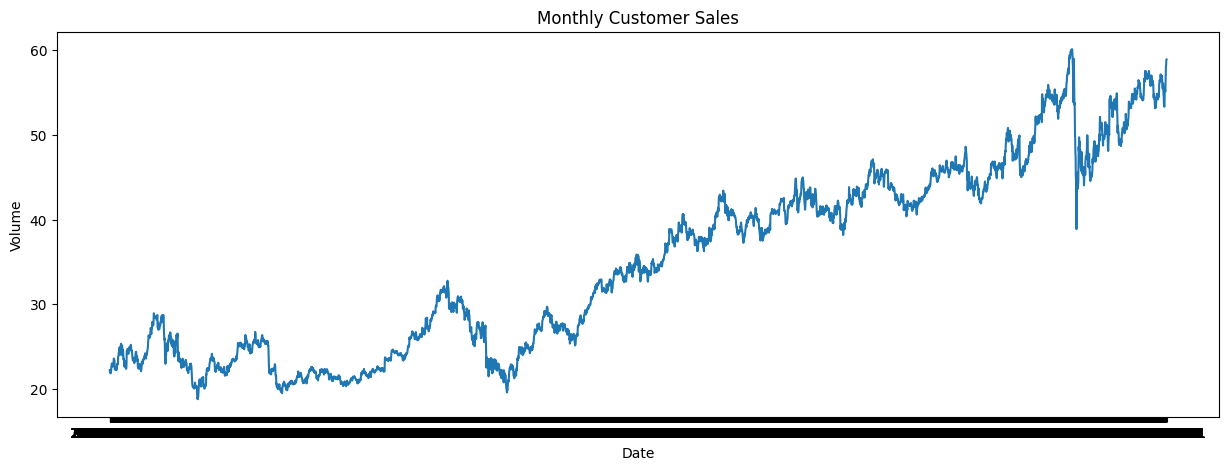

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(inventory_forecast['Date'],inventory_forecast['High'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Monthly Customer Sales')
plt.show()

In [42]:
inventory_forecast['Volume_diff']=inventory_forecast['Volume'].diff()
inventory_forecast = inventory_forecast.dropna()
inventory_forecast.head(10)

,Date,High,Low,Volume,Volume_diff
1,19-06-2001,22.045000,21.770000,5441000,-913400.0
2,20-06-2001,22.120001,21.725000,8301800,2860800.0
3,21-06-2001,22.240000,21.775000,10298800,1997000.0
4,22-06-2001,21.855000,21.295000,9211200,-1087600.0
5,25-06-2001,22.100000,21.629999,14690600,5479400.0
6,26-06-2001,22.150000,21.514999,20446600,5756000.0
7,27-06-2001,22.174999,21.875000,12653800,-7792800.0
8,28-06-2001,22.705000,22.110001,15615000,2961200.0
9,29-06-2001,22.830000,22.430000,13146800,-2468200.0
10,02-07-2001,23.025000,22.334999,7314800,-5832000.0


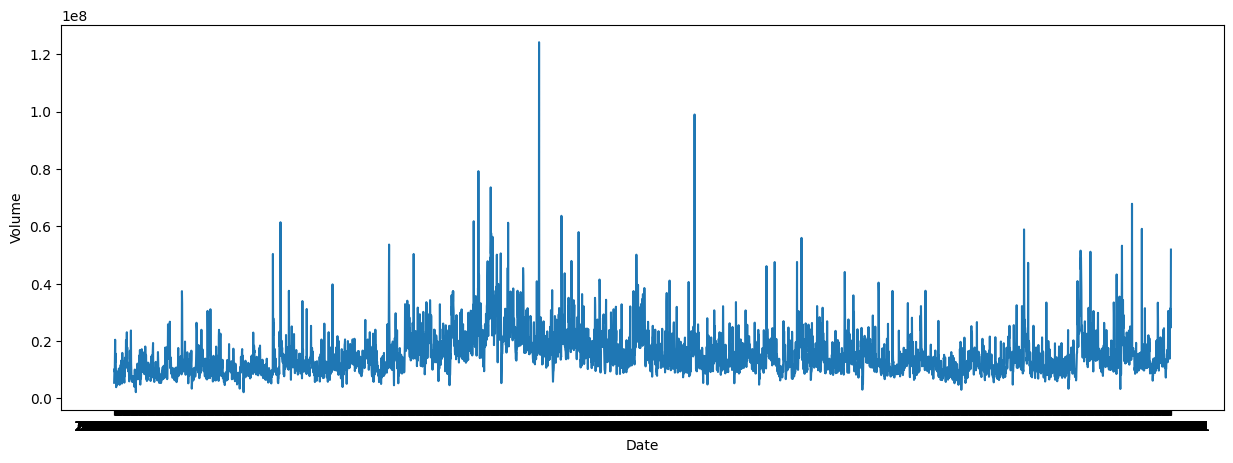

In [43]:
plt.figure(figsize=(15,5))
plt.plot(inventory_forecast['Date'], inventory_forecast['Volume'])
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

In [44]:
supervised_data = inventory_forecast.drop(['Date','Volume'], axis=1)

In [45]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['Volume_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,High,Low,Volume_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,22.745001,22.285000,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0,5756000.0,5479400.0,-1087600.0,1997000.0,2860800.0,-913400.0
1,22.840000,22.280001,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0,5756000.0,5479400.0,-1087600.0,1997000.0,2860800.0
2,22.645000,22.225000,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0,5756000.0,5479400.0,-1087600.0,1997000.0
3,22.875000,22.145000,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0,5756000.0,5479400.0,-1087600.0
4,22.750000,22.450001,-283400.0,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0,5756000.0,5479400.0
5,23.070000,22.555000,-478000.0,-283400.0,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0,5756000.0
6,23.490000,23.025000,1929600.0,-478000.0,-283400.0,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0,-7792800.0
7,23.600000,22.955000,-870400.0,1929600.0,-478000.0,-283400.0,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0,2961200.0
8,23.475000,22.805000,656800.0,-870400.0,1929600.0,-478000.0,-283400.0,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0,-2468200.0
9,23.445000,22.900000,-3150400.0,656800.0,-870400.0,1929600.0,-478000.0,-283400.0,-2205000.0,4887200.0,-468200.0,-494800.0,1618800.0,-3418600.0,-5832000.0


In [46]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (5135, 15)
Test Data Shape:  (12, 15)


In [47]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [48]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", x_train.shape)
print("y_train Shape: ", x_train.shape)
print("X_test Shape: ", x_test.shape)
print("y_test Shape: ", x_test.shape)


X_train Shape:  (5135, 14)
y_train Shape:  (5135, 14)
X_test Shape:  (12, 14)
y_test Shape:  (12, 14)


In [49]:
sales_dates = inventory_forecast['Date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)


In [50]:
act_sales=inventory_forecast['Volume'][-13:].to_list()
print(act_sales)

[18719600, 17074200, 21062400, 26624100, 23832700, 18026300, 13846400, 23151000, 31362800, 24806600, 24923800, 24696900, 51874400]


Create the Linear Regression model, and predicted Output

In [51]:
lr_model=LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre=lr_model.predict(x_test)


In [52]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set =np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set =scaler.inverse_transform(lr_pre_test_set)

In [53]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Predication")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [55]:
# print(predict_df)
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Predication'],inventory_forecast['Volume'] [-12:]))
lr_mae=mean_absolute_error(predict_df['Linear Predication'],inventory_forecast['Volume'][-12:])
lr_r2=r2_score=(predict_df['Linear Predication'],inventory_forecast['Volume'][-12:])
print("Linear Regression MSE", lr_mse)
print("Linear Regression MAE", lr_mae)
print("Linear Regression R2", lr_r2)



Linear Regression MSE 9328246.535392681
Linear Regression MAE 6297266.342521627
Linear Regression R2 (0     1.871965e+07
1     1.707425e+07
2     2.106245e+07
3     2.662416e+07
4     2.383276e+07
5     1.802636e+07
6     1.384646e+07
7     2.315106e+07
8     3.136286e+07
9     2.480666e+07
10    2.492386e+07
11    2.469696e+07
Name: Linear Predication, dtype: float64, 5148    17074200
5149    21062400
5150    26624100
5151    23832700
5152    18026300
5153    13846400
5154    23151000
5155    31362800
5156    24806600
5157    24923800
5158    24696900
5159    51874400
Name: Volume, dtype: int64)


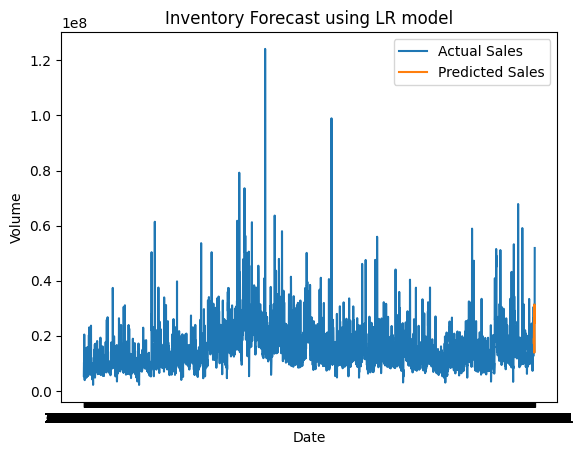

In [61]:
# Assuming the correct column name for predicted values is 'Linear Predication'

# Plot Actual Sales
plt.plot(inventory_forecast['Date'], inventory_forecast['Volume'])

# Plot Predicted Sales
plt.plot(predict_df['Date'], predict_df['Linear Predication'])

plt.title("Inventory Forecast using LR model")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()